In [278]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [279]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\gold_annotation"

In [280]:
ANNOTATION_DIR_TEMPLATE = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\platinum_annotation"

In [281]:
MOTION = "SWING_LEFT"

In [282]:
def merge_df_from_dir(dir_path: str) -> pd.DataFrame:
    file_pattern = os.path.join(dir_path, "*.csv")
    csv_files = glob.glob(file_pattern)
    print(f"Found {len(csv_files)} CSV files.")
    merged_df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
    return merged_df

In [283]:
df_test = merge_df_from_dir(ANNOTATION_DIR)

df_train = merge_df_from_dir(ANNOTATION_DIR_TEMPLATE)

Found 8 CSV files.
Found 1 CSV files.


In [284]:
# Keeps values equal to 'X', changes everything else to 'Y'
df_test['motion_type'] = df_test['motion_type'].where(df_test['motion_type'] == MOTION, f'NOT_{MOTION}')
df_train['motion_type'] = df_train['motion_type'].where(df_train['motion_type'] == MOTION, f'NOT_{MOTION}')

In [285]:
len(df_test)

269

In [286]:
len(df_train)

4

<Axes: xlabel='motion_type', ylabel='count'>

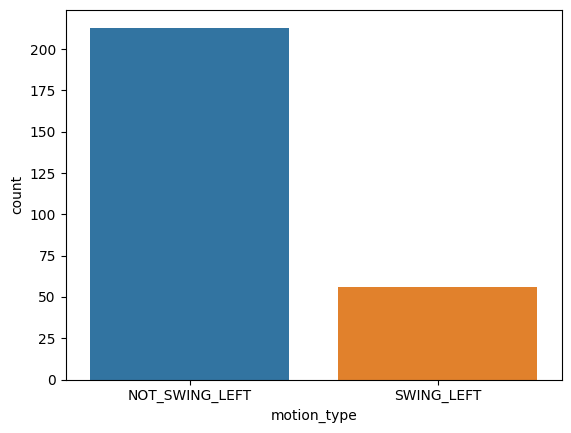

In [287]:
sns.countplot(df_test, x="motion_type", hue="motion_type")

<Axes: xlabel='motion_type', ylabel='count'>

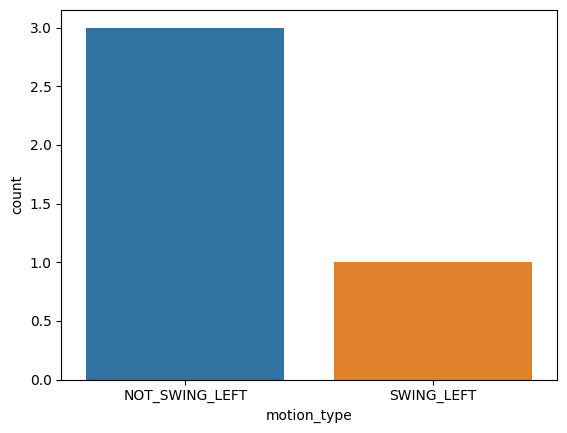

In [288]:
sns.countplot(df_train, x="motion_type", hue="motion_type")

In [289]:
X_df_test = df_test.drop(columns=["motion_type"])
y_test = df_test["motion_type"].values

In [290]:
X_df_train = df_train.drop(columns=["motion_type"])
y_train = df_train["motion_type"].values

In [291]:
n_timesteps = 6
channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"]
n_channels = len(channels)

In [292]:
X_test = np.zeros((len(df_test), n_channels, n_timesteps))

X_train = np.zeros((len(df_train), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X_test[:, c, t] = X_df_test[col_name].values
        
        X_train[:, c, t] = X_df_train[col_name].values

In [293]:
def left_zero_pad(X, target_timesteps=9):
    """
    X shape: (n_samples, n_channels, n_timesteps)
    """
    n_samples, n_channels, n_timesteps = X.shape
    pad = target_timesteps - n_timesteps

    if pad <= 0:
        return X

    padding = np.zeros((n_samples, n_channels, pad))
    X_padded = np.concatenate([padding, X], axis=2)
    return X_padded

In [294]:
X_test = left_zero_pad(X_test, target_timesteps=9)
print(X_test.shape)  # (n_samples, 6, 9)

(269, 6, 9)


In [295]:
X_train = left_zero_pad(X_train, target_timesteps=9)
print(X_train.shape)  # (n_samples, 6, 9)

(4, 6, 9)


In [296]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc_train = le.fit_transform(y_train)
y_enc_test = le.transform(y_test)

In [297]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline

In [298]:
# clf_minirocket = make_pipeline(
#     MiniRocketMultivariate(random_state=42),
#     RidgeClassifier(alpha=1.0)
# )
clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)
# clf_minirocket = InceptionTimeClassifier()

clf_minirocket.fit(X_train, y_enc_train)

KNeighborsTimeSeriesClassifier()

In [299]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [300]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [301]:
scores_accuracy = cross_val_score(
    clf_minirocket, X_test, y_enc_test, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X_test, y_enc_test, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X_test, y_enc_test, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X_test, y_enc_test, cv=5, scoring=f1_macro
)

In [302]:
print("MiniRocket Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("MiniRocket Precision:", scores_precision.mean(), "±", scores_precision.std())
print("MiniRocket Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("MiniRocket F1-score :", scores_f1.mean(), "±", scores_f1.std())

MiniRocket Accuracy : 0.8178197064989519 ± 0.06973590765505377
MiniRocket Precision: 0.7546103896103895 ± 0.10205816724824528
MiniRocket Recall   : 0.7549909392932649 ± 0.09868310149587356
MiniRocket F1-score : 0.7385073892510325 ± 0.08476333065961421


In [303]:
%%timeit
clf_minirocket.predict(np.expand_dims(X_train[0], axis=0))

13.7 ms ± 443 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


KNeighborsTimeSeriesClassifier (Euclidean)
3.48 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

KNeighborsTimeSeriesClassifier (DTW)
15.8 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

InceptionTimeClassifier
83 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)